# 1. Визуализация статистики по датасету

        Hours Studied  Previous Scores Extracurricular Activities  \
count    10000.000000     10000.000000                      10000   
unique            NaN              NaN                          2   
top               NaN              NaN                         No   
freq              NaN              NaN                       5052   
mean         4.992900        69.445700                        NaN   
std          2.589309        17.343152                        NaN   
min          1.000000        40.000000                        NaN   
25%          3.000000        54.000000                        NaN   
50%          5.000000        69.000000                        NaN   
75%          7.000000        85.000000                        NaN   
max          9.000000        99.000000                        NaN   

         Sleep Hours  Sample Question Papers Practiced  Performance Index  
count   10000.000000                      10000.000000       10000.000000  
unique           Na

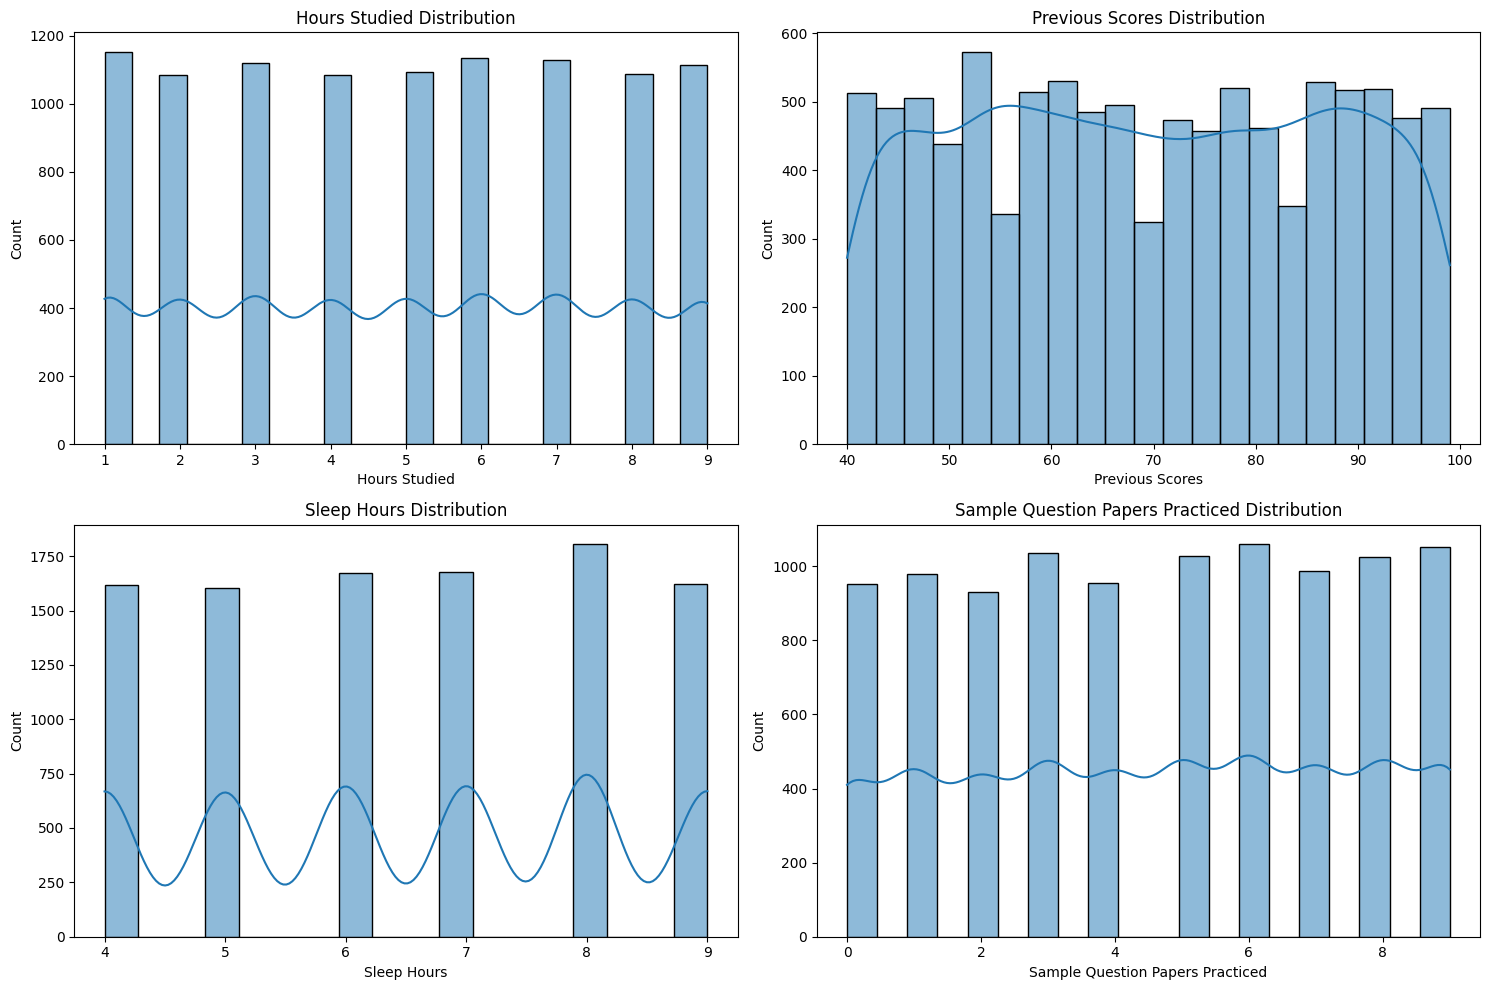

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
file_path = 'Student_Performance.csv'
data = pd.read_csv(file_path)

# Получение общей статистики
statistics = data.describe(include='all')

# Отображение статистики
print(statistics)

# Визуализация основных статистик
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(data['Hours Studied'], ax=axes[0, 0], kde=True).set(title='Hours Studied Distribution')
sns.histplot(data['Previous Scores'], ax=axes[0, 1], kde=True).set(title='Previous Scores Distribution')
sns.histplot(data['Sleep Hours'], ax=axes[1, 0], kde=True).set(title='Sleep Hours Distribution')
sns.histplot(data['Sample Question Papers Practiced'], ax=axes[1, 1], kde=True).set(title='Sample Question Papers Practiced Distribution')
plt.tight_layout()
plt.show()


# 2. Предварительная обработка данных

In [3]:
# 1. Обработка отсутствующих значений
# Заполним отсутствующие числовые значения средним (если они есть)
for column in data.select_dtypes(include=[np.number]).columns:
    data[column].fillna(data[column].mean(), inplace=True)

# Заполним отсутствующие значения категориальных признаков модой (наиболее частое значение)
for column in data.select_dtypes(include=['object']).columns:
    data[column].fillna(data[column].mode()[0], inplace=True)

# 2. Кодирование категориальных признаков
# Закодируем 'Extracurricular Activities' в числовой формат (1 для 'Yes', 0 для 'No')
data['Extracurricular Activities'] = data['Extracurricular Activities'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3. Нормировка числовых признаков
numeric_columns = ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']
data[numeric_columns] = (data[numeric_columns] - data[numeric_columns].min()) / (data[numeric_columns].max() - data[numeric_columns].min())

# Проверим результат обработки данных
print(data.head())


   Hours Studied  Previous Scores  Extracurricular Activities  Sleep Hours  \
0          0.750         1.000000                           1          1.0   
1          0.375         0.711864                           0          0.0   
2          0.875         0.186441                           1          0.6   
3          0.500         0.203390                           1          0.2   
4          0.750         0.593220                           0          0.8   

   Sample Question Papers Practiced  Performance Index  
0                          0.111111               91.0  
1                          0.222222               65.0  
2                          0.222222               45.0  
3                          0.222222               36.0  
4                          0.555556               66.0  


# 3. Разделение данных на обучающий и тестовый наборы

In [4]:
# Разделение данных на обучающий и тестовый наборы
np.random.seed(42)  # Для воспроизводимости
shuffled_indices = np.random.permutation(len(data))
test_set_size = int(len(data) * 0.3)
test_indices = shuffled_indices[:test_set_size]
train_indices = shuffled_indices[test_set_size:]

train_data = data.iloc[train_indices]
test_data = data.iloc[test_indices]

# Определение целевой переменной и признаков
X_train = train_data.drop(columns=['Performance Index'])
y_train = train_data['Performance Index']
X_test = test_data.drop(columns=['Performance Index'])
y_test = test_data['Performance Index']


# 4. Реализация линейной регрессии с использованием метода наименьших квадратов

In [5]:
# Функция для реализации линейной регрессии методом наименьших квадратов
def linear_regression(X, y):
    # Добавляем столбец единиц для свободного члена
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    
    # Вычисляем коэффициенты (метод наименьших квадратов)
    beta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    return beta

# Функция для предсказания значений
def predict(X, beta):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    return X_b.dot(beta)


# 5. Построение трёх моделей и оценка производительности

In [6]:
# Модель 1: Используем все признаки
beta_1 = linear_regression(X_train, y_train)
y_pred_1 = predict(X_test, beta_1)

# Модель 2: Используем только "Hours Studied" и "Previous Scores"
beta_2 = linear_regression(X_train[['Hours Studied', 'Previous Scores']], y_train)
y_pred_2 = predict(X_test[['Hours Studied', 'Previous Scores']], beta_2)

# Модель 3: Используем "Sleep Hours" и "Sample Question Papers Practiced"
beta_3 = linear_regression(X_train[['Sleep Hours', 'Sample Question Papers Practiced']], y_train)
y_pred_3 = predict(X_test[['Sleep Hours', 'Sample Question Papers Practiced']], beta_3)

# Оценка производительности (метрика R^2)
def r2_score(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

r2_model_1 = r2_score(y_test, y_pred_1)
r2_model_2 = r2_score(y_test, y_pred_2)
r2_model_3 = r2_score(y_test, y_pred_3)

# Оценка моделей с метрикой R^2
print(f"R^2 Модель 1 (все признаки): {r2_model_1}")
print(f"R^2 Модель 2 (Hours Studied и Previous Scores): {r2_model_2}")
print(f"R^2 Модель 3 (Sleep Hours и Sample Question Papers Practiced): {r2_model_3}")



R^2 Модель 1 (все признаки): 0.9890110607021136
R^2 Модель 2 (Hours Studied и Previous Scores): 0.9859445764337783
R^2 Модель 3 (Sleep Hours и Sample Question Papers Practiced): 0.003315890497842866


## 6. Сравнение результатов трёх моделей и выводы

In [7]:
# Сравнение и выводы
print("Сравнение моделей:")
print(f"Модель 1 (все признаки): R^2 = {r2_model_1}")
print(f"Модель 2 (Hours Studied и Previous Scores): R^2 = {r2_model_2}")
print(f"Модель 3 (Sleep Hours и Sample Question Papers Practiced): R^2 = {r2_model_3}")

# Выводы
if r2_model_1 > r2_model_2 and r2_model_1 > r2_model_3:
    print("Модель 1, использующая все признаки, имеет наибольшее значение R^2. Это указывает на то, что все признаки вместе вносят значимый вклад в предсказание производительности.")
elif r2_model_2 > r2_model_1 and r2_model_2 > r2_model_3:
    print("Модель 2, использующая только Hours Studied и Previous Scores, показала высокое значение R^2, что указывает на сильное влияние этих признаков на производительность.")
else:
    print("Модель 3, использующая Sleep Hours и Sample Question Papers Practiced, имеет значимое влияние на производительность.")

        

Сравнение моделей:
Модель 1 (все признаки): R^2 = 0.9890110607021136
Модель 2 (Hours Studied и Previous Scores): R^2 = 0.9859445764337783
Модель 3 (Sleep Hours и Sample Question Papers Practiced): R^2 = 0.003315890497842866
Модель 1, использующая все признаки, имеет наибольшее значение R^2. Это указывает на то, что все признаки вместе вносят значимый вклад в предсказание производительности.


# 7. Бонусное задание: Введение синтетического признака

In [8]:
# Введение синтетического признака
X_train['Synthetic_Feature'] = X_train['Hours Studied'] * X_train['Previous Scores']
X_test['Synthetic_Feature'] = X_test['Hours Studied'] * X_test['Previous Scores']

# Модель 4: Используем "Hours Studied", "Previous Scores" и синтетический признак
beta_4 = linear_regression(X_train[['Hours Studied', 'Previous Scores', 'Synthetic_Feature']], y_train)
y_pred_4 = predict(X_test[['Hours Studied', 'Previous Scores', 'Synthetic_Feature']], beta_4)

# Оценка модели 4
r2_model_4 = r2_score(y_test, y_pred_4)
print(f"R^2 Модель 4 (с синтетическим признаком): {r2_model_4}")

# Анализ
if r2_model_4 > max(r2_model_1, r2_model_2, r2_model_3):
    print("Введение синтетического признака улучшило модель.")
else:
    print("Синтетический признак не дал значимого улучшения модели.")


R^2 Модель 4 (с синтетическим признаком): 0.9859451654954228
Синтетический признак не дал значимого улучшения модели.
